# Lyft Bike Sharing - New York
## Fleet Management Optimisation


## Context
#### Business Description
A bike-sharing system provides individuals with rental bicycles at low-cost for short-term use. The bikes are available at designated docking stations, allowing users to pick up and drop them off at different locations.


#### Methodology
**Markov Model**

A Markov system, also known as a Markov chain, is a mathematical model used to represent a sequence of events where the probability of each event depends only on the state of the previous event. 

A Markov system (Markov chain) is defined by: 

  $\text{1. A set of states } S = \{s_1, s_2, ..., s_n\}$

  $\text{2. A transition probability matrix } P = (p_{ij})$

**Properties**:

1. The sum of probabilities in each row of the transition matrix must equal 1:
   
> $\sum_{j=1}^p p_{ij} = 1 \quad \text{for all } i$

2. The Markov property states that the probability of transitioning to a future state depends only on the current state:

> $P(X_{n+1} = j | X_n = i, X_{n-1} = i_{n-1}, ..., X_1 = i_1) = P(X_{n+1} = j | X_n = i) = p_{ij}$

3. The evolution of the system is described by:
   
> $\pi_{n+1} = \pi_n P$

4. For a system with initial state $\pi_0$ the position at time n is given by:

> $\pi_n = \pi_0 P^n$


**Implementation**:

* A transition is defined as a bike ride between two stations.
* Rows with missing values have been dropped.
* The month of August, year 2024 was included in the analysis.
* Geographical coordinates were not considered.
* Matrix multiplication, not agent simulation.
* The chain is time-homogenous.

**Pros**:
* Transparent and interpretable
* Easy to re-calibrate in development
* Lightweight computation (matrix multiplication)

**Cons**:
* Ignores covariates
* Not scalable if state space grows significantly

# 0.0 Libraries & Data

In [1]:
import os
import random
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt

folder_path = '202408-citibike-tripdata'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

trips_ = None
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    tmp_ = pd.read_csv(file_path, low_memory=False)
    trips_ = tmp_ if trips_ is None else pd.concat([trips_, tmp_])

print(f"""No. rows, No. columns: {trips_.shape}""")
print(trips_.dtypes)
trips_.head(5)

No. rows, No. columns: (4603575, 14)
rideable_type_duplicate_column_name_1     object
ride_id                                   object
rideable_type                             object
started_at                                object
ended_at                                  object
start_station_name                        object
start_station_id                          object
end_station_name                          object
end_station_id                            object
start_lat                                float64
start_lng                                float64
end_lat                                  float64
end_lng                                  float64
member_casual                             object
dtype: object


,rideable_type_duplicate_column_name_1,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,electric_bike,06967465A2A0ABD9,electric_bike,2024-08-11 13:40:50.958,2024-08-11 13:53:24.149,1 Ave & E 18 St,5854.09,W 20 St & 10 Ave,6306.01,40.733812,-73.980544,40.745686,-74.005141,member
1,electric_bike,8698B37420563CCC,electric_bike,2024-08-05 08:12:49.336,2024-08-05 08:48:03.320,W 181 St & Riverside Dr,8381.04,Hudson Blvd W & W 36 St,6611.07,40.851680,-73.941860,40.756765,-73.999714,member
2,electric_bike,E7CB10418EBA1F43,electric_bike,2024-08-09 13:39:16.596,2024-08-09 13:57:01.755,1 Ave & E 18 St,5854.09,Fulton St & Adams St,4637.06,40.733812,-73.980544,40.692418,-73.989495,member
3,electric_bike,25C23D06829C695C,electric_bike,2024-08-07 15:01:31.370,2024-08-07 15:08:41.839,Morris Ave & E 163 St,8036.05,Morris Ave & E 171 St,8209.01,40.827230,-73.917656,40.838990,-73.910900,member
4,classic_bike,D11FB08CCDC5E48F,classic_bike,2024-08-14 15:49:34.500,2024-08-14 15:54:04.601,82 St & Broadway,6132.01,Elmhurst Ave & Forley St,6240.05,40.742810,-73.882960,40.746150,-73.877630,member


In [11]:
%matplotlib inline

# 0.1 Solution Implementation Class

In [4]:
class TripsMarkov():
    def __init__(self, trips, steps):
        self.steps = steps
        self.trips = trips.copy(deep=True)
        self.tms = None
        self.traffic = None

        self.tidy()

    def tidy(self):
        # Keep necessary columns
        self.trips.drop(['rideable_type_duplicate_column_name_1', 'start_lat', 'end_lat', 'start_lng', 'end_lng'], axis = 1, inplace = True)
        # Create other variables
        self.trips = self.trips.assign( started_at = pd.to_datetime(self.trips.started_at),
                      ended_at = pd.to_datetime(self.trips.ended_at)
                    ).dropna()
        self.trips = self.trips.assign(
            hr_start = self.trips.started_at.dt.hour,
            duration_min = (self.trips.ended_at - self.trips.started_at).dt.total_seconds() / 60,
            time_label = pd.cut(self.trips.started_at.dt.hour,
                        bins=[-1, 6, 12, 18, 24],
                        labels=['night', 'morning', 'day', 'noon'],
                        include_lowest=True)
            )

        print(f"""No. rows, No. columns: {self.trips.shape}""")

    def calculate_statistics(self, column: str, df = None, plot_: bool = False, bins: int = 50):

        if df is None:
            df = self.trips
        elif isinstance(df, str):
            if df == 'traffic':
                df = self.traffic

        if df is None:
            raise ValueError("Must run traffic_flow() if df = 'traffic'")
        
        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in DataFrame.")

        quantiles = {
            'Minimum': df[column].min(),
            '5-th percentile': df[column].quantile(0.05),
            'Q1': df[column].quantile(0.25),
            'Median': df[column].median(),
            'Q3': df[column].quantile(0.75),
            '95-th percentile': df[column].quantile(0.95),
            'Maximum': df[column].max(),
            'Range': df[column].max() - df[column].min(),
            'Interquartile range (IQR)': df[column].quantile(0.75) - df[column].quantile(0.25)
        }
    
        descriptive_stats = {
            'Standard deviation': df[column].std(),
            'Coefficient of variation (CV)': df[column].std() / df[column].mean(),
            'Kurtosis': df[column].kurtosis(),
            'Mean': df[column].mean(),
            'Skewness': df[column].skew(),
            'Variance': df[column].var()
            }

        # Return statistics
        statistics = {
            **quantiles,
            **descriptive_stats
        }

        if plot_:
            fig, ax = plt.subplots(figsize=(5, 3))
            ax.hist(df[column], bins=bins, alpha=0.7, color='blue', edgecolor='black')
            
            # Adding titles and labels
            ax.set_title(f'Histogram of {column}')
            ax.set_xlabel(column)
            ax.set_ylabel('Frequency')
            
            # Add mean line
            mean_value = df[column].mean()
            ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1, label='Mean')
            
            ax.grid(axis='y', alpha=0.75)
            ax.legend()

            plt.show()
    
        return statistics

    def traffic_flow(self):
        start = self.trips.groupby(['start_station_id']).size().reset_index(name='count_out').assign(station = lambda x: x['start_station_id'])
        end = self.trips.groupby(['end_station_id']).size().reset_index(name='count_in').assign(station = lambda x: x['end_station_id'])

        traffic = pd.merge(start, end, on = 'station', how = 'outer').fillna(0).assign(
                                        outflow = lambda x: x['count_out'] - x['count_in']
                                            ).drop(['start_station_id', 'end_station_id'], axis = 1).loc[:, 
        ['station', 'count_out', 'count_in', 'outflow']]
        self.traffic = traffic
        return traffic
        
    def create_transition(self, df = None):
        
        if df is None:
            df = self.trips

        # Ensure square matrix
        all_stations = pd.concat([df['start_station_id'], df['end_station_id']]).unique()

        tm = pd.crosstab(df['start_station_id'], df['end_station_id'], normalize=1)
        tm = tm.reindex(index=all_stations, columns=all_stations)

        tmp_ = tm.copy()
        tmp_[pd.isnull(tmp_)] = 0
        np.fill_diagonal(tmp_.values, 1 - tmp_.filter(tmp_.columns).sum())

        tm[pd.isnull(tm)] = tmp_
        
        return tm.T

    def create_matrices(self):
        filter_list = ['rideable_type', 'member_casual']  # 'time_label'
        self.filter_list = filter_list
        
        tms_ = {}
        df = self.trips
        
        for col in filter_list:
            unique_values = df[col].unique()
            
            for value in unique_values:
                facet = df[df[col] == value]
                key = f"{col}-{value}"
                tms_[key] = self.create_transition(df=facet)
    
        tms_['all'] = self.create_transition(df=df)

        self.tms = tms_
        
        return tms_

    def make_transitions(self, starting_state=None, tm_name: str='all'):
        
        # self.create_matrices()
        # if tm_name not in self.tms.keys():
        #     raise ValueError(f"{self.filter_list} are valid matrices.")
            
        tm_ = self.tms[tm_name]

        if starting_state is None:
            starting_state = np.ones(tm_.shape[1])
            
        paths = []
        step = starting_state / sum(starting_state)
        for i in range(self.steps):
            paths.append(step)
            step = np.dot(step, tm_)
            step = step / np.sum(step)  # Normalize

        self.paths = pd.DataFrame(paths)

        return pd.DataFrame(paths)

    def plot_sample_paths(self, sample=None):

        if sample is None:
            sample = random.sample(list(range(self.paths.shape[1])), 1)[0]
            df_subset = self.paths.iloc[:, sample : sample + 15] * 100

            print(list(range(sample, sample + 15)))
        else:
            df_subset = self.paths.iloc[:, sample] * 100
        

        plt.figure(figsize=(8, 5))
        for column in df_subset.columns:
            plt.plot(df_subset.index, df_subset[column], label=column)
        
        plt.title('Sample Paths of 15 Stations')
        plt.xlabel('Step')
        plt.ylabel('Fleet allocation %')
        plt.legend()
        plt.grid(True)
        plt.show()
        

    # def score_outcome(self, df):
    #     first_row = df.iloc[0]
    #     last_row = df.iloc[-1]

    #     difference = first_row - last_row
    #     return np.mean(difference)
        
    
    # def simulation(self, starting_state_ = None, tm_name: str='all', n_simulations: int=100, shape : int = 2288):

        
    #     scores = []
        
    #     # print(rand_)
    #     # print(len(rand_))
    #     # nrows = self.paths.shape[1]
    #     nrows = shape
    #     rand_ = np.ones(shape)
    #     print(rand_)
    #     for i in range(n_simulations):
            
    #         self.make_transitions(starting_state = rand_)
            
    #         score = self.score_outcome(self.paths)
    #         start_state = rand_
            

    #         scores.append((score, start_state))
    #         rand_ = np.array(list([random.random() for x in range(nrows)]))
            
    #     self.simul_res = scores
    #     return scores
            
        

# 1.0 Data Analysis

In [5]:
TripsMarkovClass = TripsMarkov(trips = trips_, steps = 100)

No. rows, No. columns: (4587868, 12)


## 1.1 Station Traffic

The histogram captures the uneven outflow of rides between stations, with 50% of stations either losing or gaining bikes at the end of the month.

C:\Users\alexa\AppData\Local\Temp\ipykernel_24568\1222471060.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  'Coefficient of variation (CV)': df[column].std() / df[column].mean(),


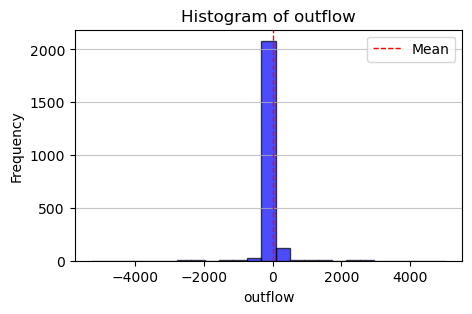

Minimum: -5228.0
5-th percentile: -102.65
Q1: -16.0
Median: -4.0
Q3: 12.0
95-th percentile: 119.65
Maximum: 4994.0
Range: 10222.0
Interquartile range (IQR): 28.0
Standard deviation: 317.22
Coefficient of variation (CV): inf
Kurtosis: 93.51
Mean: 0.0
Skewness: -0.18
Variance: 100627.48


,station,count_out,count_in,outflow
962,5779.10,6296.0,1302.0,4994.0
1236,6364.10,8319.0,5233.0,3086.0
789,5343.10,5245.0,2445.0,2800.0
992,5872.10,4880.0,2183.0,2697.0
708,5137.10,3464.0,805.0,2659.0
...,...,...,...,...
707,5137.1,469.0,3114.0,-2645.0
991,5872.1,575.0,3280.0,-2705.0
788,5343.1,621.0,3494.0,-2873.0
1235,6364.1,988.0,3867.0,-2879.0


In [6]:
# See traffic in/out station
traffic = TripsMarkovClass.traffic_flow()
stats = TripsMarkovClass.calculate_statistics(df = "traffic", column = 'outflow', plot_=True, bins = 25)

for key, value in stats.items():
        print(f"{key}: {np.round(value, 2)}")

traffic.sort_values(by = ['outflow'], ascending = False)

In [7]:
# Trips out == trips in
traffic[['count_out', 'count_in']].sum()

count_out    4587868.0
count_in     4587868.0
dtype: float64

## 1.2 Outgoing from Station

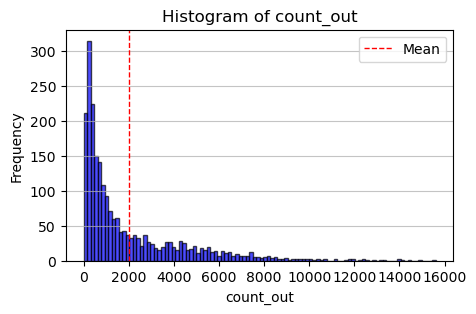

Minimum: 0.0
5-th percentile: 84.0
Q1: 338.75
Median: 928.0
Q3: 2826.5
95-th percentile: 7148.9
Maximum: 15612.0
Range: 15612.0
Interquartile range (IQR): 2487.75
Standard deviation: 2438.961
Coefficient of variation (CV): 1.2163
Kurtosis: 4.0408
Mean: 2005.1871
Skewness: 1.9151
Variance: 5948530.9374


,station,count_out,count_in,outflow,count_out_percent,start_station_id,start_station_name
0,5788.13,15612.0,15685.0,-73.0,0.340289,5788.13,Lafayette St & E 8 St
1,6140.05,14880.0,14918.0,-38.0,0.324334,6140.05,W 21 St & 6 Ave
2,5329.03,14515.0,14705.0,-190.0,0.316378,5329.03,West St & Chambers St
3,6233.04,14197.0,14225.0,-28.0,0.309447,6233.04,Pier 61 at Chelsea Piers
4,6450.05,13977.0,14181.0,-204.0,0.304651,6450.05,8 Ave & W 31 St
5,6726.01,13897.0,13867.0,30.0,0.302908,6726.01,11 Ave & W 41 St
6,5905.12,13395.0,13363.0,32.0,0.291966,5905.12,Broadway & E 14 St
7,5905.14,13121.0,13328.0,-207.0,0.285993,5905.14,University Pl & E 14 St
8,6331.01,12853.0,12895.0,-42.0,0.280152,6331.01,W 31 St & 7 Ave
9,6765.01,12494.0,12561.0,-67.0,0.272327,6765.01,12 Ave & W 40 St


In [9]:
# See initial fleet allocation

traffic = TripsMarkovClass.traffic_flow().assign(count_out_percent = lambda x: x['count_out'] / x['count_out'].sum() * 100)
stats= TripsMarkovClass.calculate_statistics(df = traffic, column = 'count_out', plot_=True, bins = 100)
for key, value in stats.items():
        print(f"{key}: {np.round(value, 4)}")

pd.merge(traffic.sort_values('count_out', ascending=False).head(10), 
         trips_[['start_station_id', 'start_station_name']].drop_duplicates(subset = ['start_station_id', 'start_station_name']), 
         left_on = 'station', 
         right_on = 'start_station_id', 
         how = 'left')

## 1.3 Average Ride Duration

The step in the Markov chain constitutes one customer ride. 

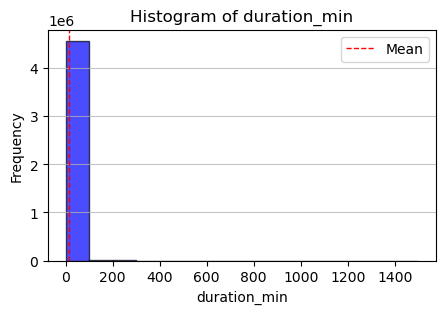

Minimum: 1.0
5-th percentile: 2.46
Q1: 5.53
Median: 9.67
Q3: 16.97
95-th percentile: 36.09
Maximum: 1498.66
Range: 1497.66
Interquartile range (IQR): 11.44
Standard deviation: 20.93
Coefficient of variation (CV): 1.51
Kurtosis: 1233.56
Mean: 13.85
Skewness: 25.83
Variance: 437.87


In [10]:
stats = TripsMarkovClass.calculate_statistics(df = None, column = 'duration_min', plot_ = True, bins = 15)

for key, value in stats.items():
        print(f"{key}: {np.round(value, 2)}")

# 2.0 Stages of Model Implementation

## 2.1 Transition Matrices

In [11]:
# Get the transition matrices for ensemble and segments
matrices = TripsMarkovClass.create_matrices()
matrices.keys()

dict_keys(['rideable_type-electric_bike', 'rideable_type-classic_bike', 'member_casual-member', 'member_casual-casual', 'all'])

In [12]:
# E.g.
matrices['all'].sum(axis = 1)

end_station_id
5854.09    1.0
8381.04    1.0
8036.05    1.0
6132.01    1.0
4077.07    1.0
          ... 
HB105      1.0
JC057      1.0
JC075      1.0
HB609      1.0
JC059      1.0
Length: 2288, dtype: float64

**Insight**:
`examine the transition probabilities between different segments to discover customer preferences that drive engagement`

In [14]:
df_classic = matrices['rideable_type-classic_bike'].loc[matrices['rideable_type-classic_bike'].index == "5779.1", :].T.reset_index()
df_electric = matrices['rideable_type-electric_bike'].loc[matrices['rideable_type-electric_bike'].index == "5779.1", :].T.reset_index()

# Rename columns for clarity
df_classic.columns = ['index', 'classic_bike']
df_electric.columns = ['index', 'electric_bike']

# Step 2: Perform inner join
joined_df = pd.merge(df_classic, df_electric, on='index', how='inner')

# Step 3: Calculate the difference
joined_df['difference'] = joined_df['electric_bike'] - joined_df['classic_bike']

# Step 4: Sort by the largest difference
result = joined_df.sort_values('difference', ascending=False).dropna()

# Display the result
print(result)

        index  classic_bike  electric_bike  difference
972   6197.08      0.010376       0.028308    0.017932
1530  6122.09      0.012880       0.020262    0.007382
1108  5476.03      0.001431       0.007151    0.005720
158   5445.07      0.001073       0.005959    0.004886
1127  5602.06      0.000358       0.005066    0.004708
...       ...           ...            ...         ...
668   5669.10      0.017889       0.005364   -0.012526
1546  5779.09      0.016100       0.000894   -0.015206
1178  5746.14      0.020036       0.004172   -0.015864
1377  5626.15      0.028265       0.011025   -0.017240
347   5626.13      0.031485       0.007747   -0.023737

[2250 rows x 4 columns]


## 2.2 Make Transitions

In [15]:
# Generate a path for the system starting from even distribution of fleet across stations
transitions = TripsMarkovClass.make_transitions(starting_state = None)
transitions.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287
0,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,...,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437
1,0.000865,0.000358,0.000646,0.000763,0.000519,0.000804,0.000410,0.001100,0.000536,0.000870,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000766,0.000334,0.000708,0.000727,0.000484,0.000738,0.000500,0.001149,0.000579,0.001119,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


**Insight** `The system appears to have some pseudo-absorbent states i.e. bikes collect there and are never taken out`

[1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403]


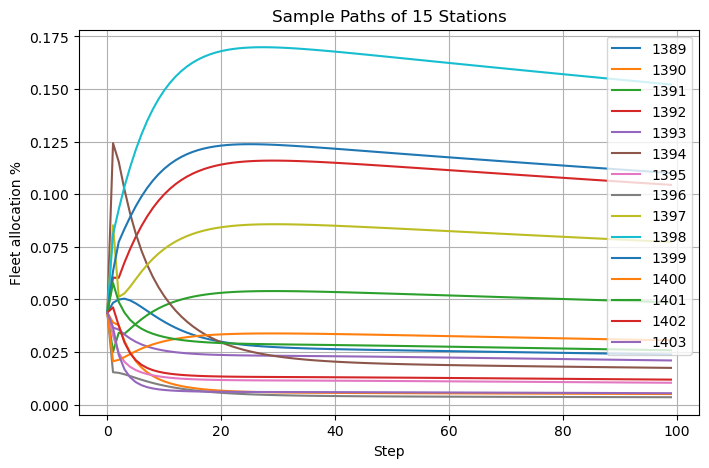

In [24]:
TripsMarkovClass.plot_sample_paths()

[42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


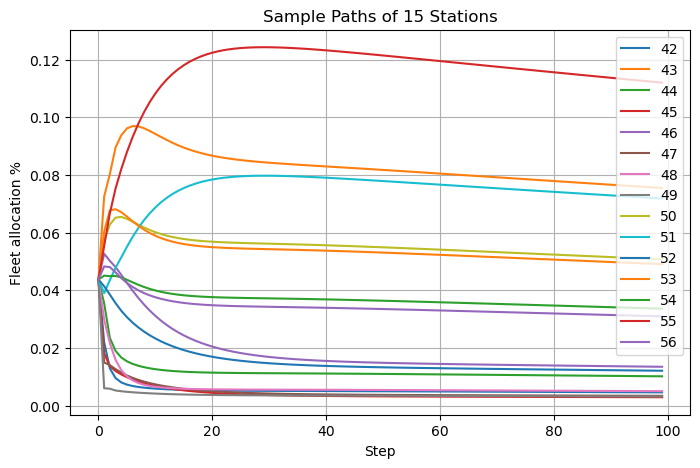

In [21]:
TripsMarkovClass.plot_sample_paths()

In [23]:
# Each column represents a station, and each row represents the distribution of the fleet across the stations; rows must add up to 1
transitions.sum(axis = 1)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
95    1.0
96    1.0
97    1.0
98    1.0
99    1.0
Length: 100, dtype: float64

In [25]:
# Generate a path for the system starting from the empirical distribution of demand across stations
trf2 = traffic[['station', 'count_out']].reindex(matrices['all'].index).reset_index()
trf3 = pd.merge(trf2, traffic, left_on = 'end_station_id', right_on = 'station', how = 'inner')
trf4 = np.array(trf3.count_out_y)

transitions = TripsMarkovClass.make_transitions(starting_state = trf4)
transitions.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287
0,0.001597,0.000181,0.000226,0.000189,0.000466,0.000215,0.000881,0.001237,0.000939,0.001970,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001594,0.000183,0.000224,0.000188,0.000456,0.000213,0.000873,0.001221,0.000931,0.001960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001596,0.000184,0.000223,0.000187,0.000452,0.000214,0.000870,0.001212,0.000932,0.001961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501]


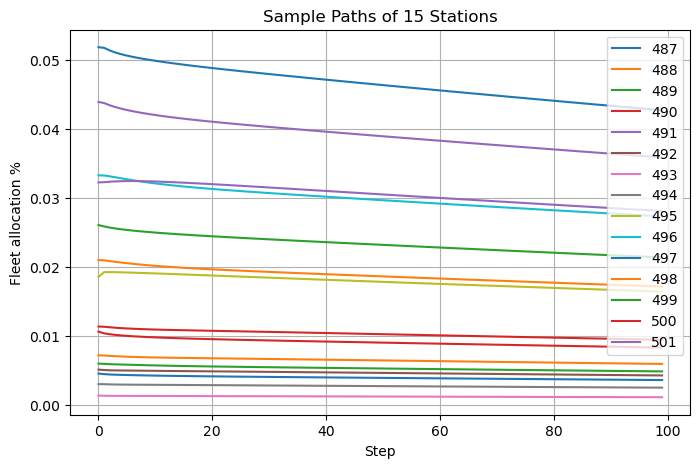

In [27]:
TripsMarkovClass.plot_sample_paths()

**Insight** `This can be used to find the most contagious stations, thus reducing the need to re-distribute bikes`

In [28]:
# What happens if your entire fleet is in one station
arr = np.zeros(2288)
arr[0] = 1
transitions = TripsMarkovClass.make_transitions(starting_state = arr)
transitions.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287
0,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.016823,0.00000,0.000000,0.000000,0.000138,0.000000,0.001241,0.000552,0.000414,0.000138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.006018,0.00004,0.000011,0.000014,0.000109,0.000018,0.000974,0.000388,0.000764,0.001068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229]


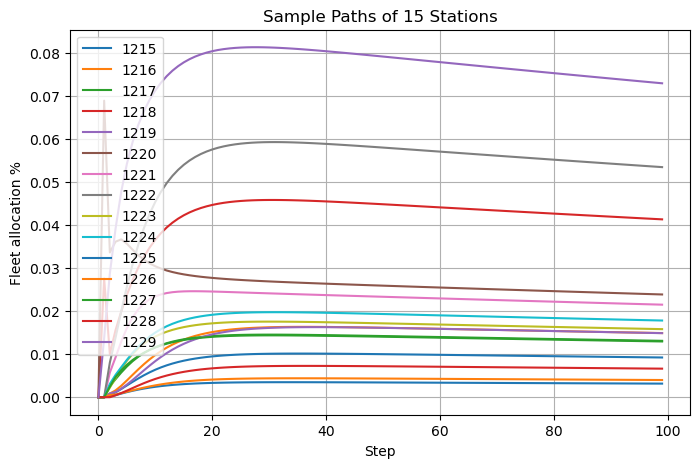

In [33]:
TripsMarkovClass.plot_sample_paths()

## 2.3 Simulate Scenarios

In [39]:
# # POC, but for example can simulate various scenarios and score the outcome
# scores = TripsMarkovClass.simulation(n_simulations = 10)
# res_ = pd.DataFrame(scores, columns = ['score', 'initial_state'])
# res_ = res_.sort_values('score').iloc[0]

# state = res_.iloc[1]


In [40]:
# # Generate a path for the system starting from an initial distribution that minimizes the change between start and end
# transitions = TripsMarkovClass.make_transitions(starting_state = state)
# transitions.head(3)

In [41]:
# TripsMarkovClass.plot_sample_paths(sample = [1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229])